# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

**Загрузим все библиотеки и модули, которые использвали в ходе работы**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

**Подгрузим таблицы**

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
pd.set_option('display.max_columns', 100)

# 2. Анализ данных

### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

Выведем таблицу gold_recovery_trainь

In [4]:
gold_recovery_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
gold_recovery_train.info() # В данных встречаются пропуски, которые надо будет обрабатываь. Удалять строки с Nan не будем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

**Копируем выборку gold_recovery_train и попробуем метод  интерполяции для заполнения пустых данных в ней. Если метод окажется успешным в дальнейшем заполним пропуски во всех таблицах**

In [6]:
gold_recovery_train1=gold_recovery_train.copy(deep = True)

**Пишем расчетную функцию эффективности обогащения**

In [7]:
def routher_effectivness(data):
    #_________________________________________дропаем пустые ячейки
    data = data.dropna()
    #_________________________________________тело функции
    
    data['rougher.output.recovery_calc'] = ((data['rougher.output.concentrate_au'] *
        (data['rougher.input.feed_au'] - data['rougher.output.tail_au'])) /
        (data['rougher.input.feed_au'] * (data['rougher.output.concentrate_au'] - 
                                          data['rougher.output.tail_au'])))*100
    #________________________________________убираем вылеты для расчета mae
    data.loc[data['rougher.output.recovery_calc'] > 100, 'rougher.output.recovery_calc'] = 100
    data.loc[data['rougher.output.recovery_calc'] < 0,   'rougher.output.recovery_calc'] = 0
    #data['rougher.output.recovery_calc']= data['rougher.output.recovery_calc'].fillna(0)
    #________________________________________вычисляем mae
    mae = mean_absolute_error(
        data['rougher.output.recovery'], data['rougher.output.recovery_calc'])  
    return print("MAE = {:.2f}".format(mae))    

In [8]:
routher_effectivness(gold_recovery_train1)

MAE = 0.00


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


**Вывод: mae равен 0, убеждаемя в кореектности параметра эффективности обогащения**

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

**Найдем признаки которых нет в тестовой выборке.**

In [9]:
test = list(gold_recovery_test.columns)

In [10]:
train = list(gold_recovery_train.columns)

In [11]:
missing_data = []
for i in train:
    if i not in test:
        missing_data.append(i)

In [12]:
missing_data

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Вывод отсуствующие в тестовой выборке данные имеют суффикс output и calculation, cледовательно это измерения полученных концентраций хвостов и металлов на каждом из этапов а также расчет параметров для флотационной установки. Скорее всего перечисленные параметры не влияют на технологический процесс а являются его следствием, поэтому и не учитываются в тестовой выборке как нужные для предсказания. Для обучения тренировочной модели эти параметры мы тоже опустим, чтобы обе моделии предсказывали параметры на одинаковых данных.**

### Предобработка данных

**Так как все данные были записаны с часовым интревалом, то логично предположить о похожести пропушенных значений с соседними. Соответственно для восстановления данных воспользуемся методом интерполяции**

In [13]:
gold_recovery_train=gold_recovery_train.interpolate(method='linear')
gold_recovery_test = gold_recovery_test.interpolate(method= 'linear')
gold_recovery_full = gold_recovery_full.interpolate(method = 'linear')

## 2. Проанализируйте данные

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

### Cмотрим изменение концентрации золота

**Строим гистограммы расделения концентраций золота на разных этапах.**

rougher.input.feed_ag                                 16778 non-null float64
rougher.input.feed_pb                                 16632 non-null float64
rougher.input.feed_rate                               16347 non-null float64
rougher.input.feed_size                               16443 non-null float64
rougher.input.feed_sol                                16568 non-null float64
rougher.input.feed_au  

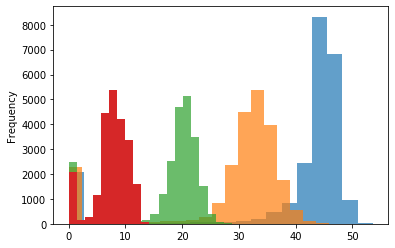

In [14]:
for i in gold_recovery_full:
    if "output.concentrate_au" in i:
        gold_recovery_full[i].plot(kind = 'hist',bins = 20, alpha = 0.7,y = 'i');
gold_recovery_full['rougher.input.feed_au'].plot(kind="hist")

**Концентрация золота от этапа к этапу возрастает, практически на одно число (около 15 единиц)**

### Cмотрим изменение концентрации серебра

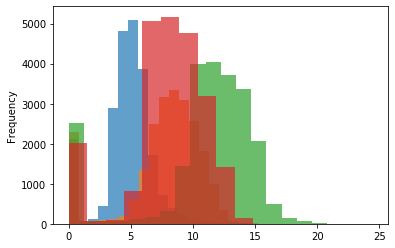

In [15]:
for i in gold_recovery_full:
    if "output.concentrate_ag" in i:
        gold_recovery_full[i].plot(kind = 'hist',bins = 20, alpha = 0.7,y = 'i');
gold_recovery_full['rougher.input.feed_ag'].plot(kind="hist", alpha = 0.7)

**Концентрация серебра в конечном счете падает**

### Смотрим изменение концентрации свинца

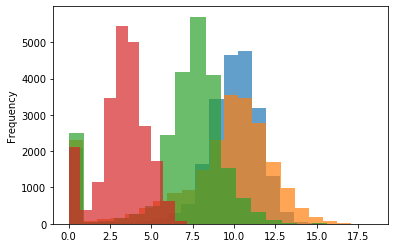

In [16]:
for i in gold_recovery_full:
    if "output.concentrate_pb" in i:
        gold_recovery_full[i].plot(kind = 'hist',bins = 20, alpha = 0.7);
gold_recovery_full['rougher.input.feed_pb'].plot(kind="hist", alpha = 0.7)

**Концентрация свинца не имеет линейной тенденции изменения от этапу к этапу**

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

***rougher.input.feed_size***

**Сравниваем размеры гранул primary_cleaner.input.feed_size. Построим гистограммы методом plot  и добавим статистику о распределениях в общий датафрейм**

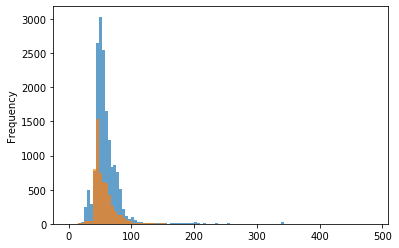

In [17]:
gold_recovery_train['rougher.input.feed_size'].plot(kind = 'hist',bins = 100, alpha = 0.7);
gold_recovery_test['rougher.input.feed_size'].plot(kind = 'hist',bins = 100, alpha = 0.7);

In [18]:
size_train = pd.DataFrame(gold_recovery_train['rougher.input.feed_size'].describe())
size_test = pd.DataFrame(gold_recovery_test['rougher.input.feed_size'].describe())
size_rougher= pd.concat([size_train, size_test], axis=1, join='inner')
size_rougher

,rougher.input.feed_size,rougher.input.feed_size
count,16860.000000,5856.000000
mean,59.152776,55.886800
std,26.131277,22.704970
min,9.659576,0.046369
25%,47.540138,43.865121
50%,54.029671,49.964796
75%,65.272775,61.615634
max,484.967466,477.445473


***primary_cleaner.input.feed_size***

**Сравниваем размеры гранул primary_cleaner.input.feed_size. Аналогично построим гистограммы и добавим статистику о распределениях в общий датафрейм**

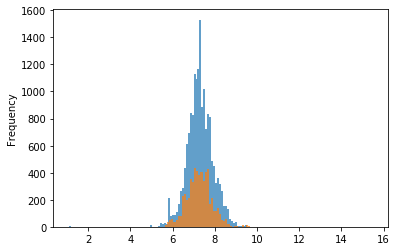

In [19]:
gold_recovery_train['primary_cleaner.input.feed_size'].plot(kind = 'hist',bins = 100, alpha = 0.7);
gold_recovery_test['primary_cleaner.input.feed_size'].plot(kind = 'hist',bins = 100, alpha = 0.7);

In [20]:
size_train = pd.DataFrame(gold_recovery_train['primary_cleaner.input.feed_size'].describe())
size_test = pd.DataFrame(gold_recovery_test['primary_cleaner.input.feed_size'].describe())
size = pd.concat([size_train, size_test], axis=1, join='inner')
size

,primary_cleaner.input.feed_size,primary_cleaner.input.feed_size
count,16860.000000,5856.000000
mean,7.297285,7.264651
std,0.619166,0.611526
min,1.080000,5.650000
25%,6.940000,6.885625
50%,7.285000,7.259333
75%,7.700000,7.650000
max,10.470000,15.500000


**Вывод распределения тестовой  и тренеровочной выборки имеют достаточно близкую статистику для корректного продолжения работы.**

## Комментарий наставника
<span style="color:green">Прекрасно! Вопросов нет.</span>

### 2.3 Исследованы суммарные концентрации

### *Final*

**Исследуем суммарную концентрацию всех металлов на разных стадиях: в сырье, в черновом и финальном концентратах. Просуммируем концентрации по каждому из металлов на конечный момент тех. процесса**

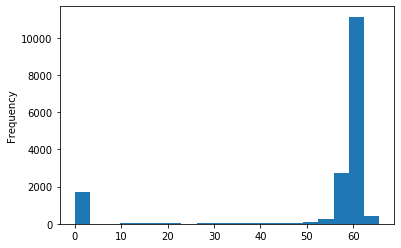

In [21]:
gold_recovery_train1['final_sum'] = (
    gold_recovery_train['final.output.concentrate_ag'] 
    + gold_recovery_train['final.output.concentrate_pb'] + 
    gold_recovery_train['final.output.concentrate_au'])
gold_recovery_train1['final_sum'].plot(kind = 'hist',bins = 20)

### *Routher*

**Аналогично найдем суммарную концентрацию для этапа routher**

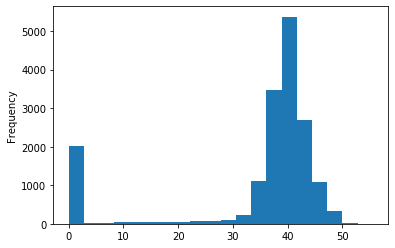

In [22]:
gold_recovery_train1['rougher_sum'] = (
    gold_recovery_train['rougher.output.concentrate_ag'] 
    + gold_recovery_train['rougher.output.concentrate_pb'] + 
    gold_recovery_train['rougher.output.concentrate_au'])
gold_recovery_train1['rougher_sum'].plot(kind = 'hist',bins = 20)

### *Input*

**Аналогично найдем суммарную концентрацию для этапа routher**

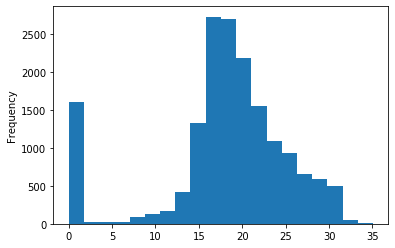

In [23]:
gold_recovery_train1['input_sum'] = (
    gold_recovery_train['rougher.input.feed_ag'] 
    + gold_recovery_train['rougher.input.feed_pb'] + 
    gold_recovery_train['rougher.input.feed_au'])
gold_recovery_train1['input_sum'].plot(kind = 'hist',bins = 20)

**Вывод: вылеты есть, будем чистить данные от них**

**Для начала создадим список по столбцам, где зафиксировали выбросы**

In [24]:
list_to_clean = ['final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_au',
                 'rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_au',
                'rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_au']

**Теперь найдем нижнюю границу концентрации по которой будем чистить датасеты. Опишем статистику по концетрациям с шагом 0.05**

In [25]:
percent = np.linspace(0,1,21)
gold_recovery_train[
    ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']].describe(percentiles =percent)

,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_au
count,16860.000000,16860.000000,16860.000000
mean,10.535823,6.854436,17.327961
std,4.490524,2.953953,6.992066
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000
10%,0.010000,0.010000,0.010000
15%,8.107963,4.748604,13.841303
20%,9.448459,5.967985,16.561782
25%,9.946383,6.326960,17.398683


**Кажется, что выбросы в концентрации фиксируются до уровня 0.01, что отвечает 10% персентиле**

**Напишем функцию, дающую список индексов по условию конецтрации меньшей 0.01 единиц. Функция удаляет строки по полученным индексам**

In [26]:
def zero_index(data):
    #Комментарий: советую добавлять в качестве входных аргументов к функции все переменные, которые в ней так или 
    #иначе используются. Это позволит сделать функцию универсальной. То есть list_to_clean тоже нужно было передать на вход
    #функции вместе с data.
    indexNames = []
    for i in list_to_clean:
        indexNames = data[ data[i] <0.01].index
        data.drop(indexNames , inplace=True)
    return data

**Применим функцию к тренеровочной и полной выборке**

In [27]:
gold_recovery_train = zero_index(gold_recovery_train)
gold_recovery_full = zero_index(gold_recovery_full)

**Проверим результаты для стадии rougher.input, те. аналогично сделаем суммарную конц. и построим график**

In [28]:
gold_recovery_train1['input_sum'] = (
    gold_recovery_train['rougher.input.feed_ag'] 
    + gold_recovery_train['rougher.input.feed_pb'] + 
    gold_recovery_train['rougher.input.feed_au'])

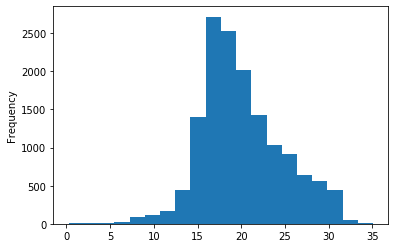

In [29]:
gold_recovery_train1['input_sum'].plot(kind = 'hist',bins = 20)

**Вывод: График стал выглядеть лучше, от анамалий в тренеровчном и полном дататесатах избавились, теперь избавимся от удаленных строк в тестовой выборке.**

In [30]:
gold_recovery_test= gold_recovery_test[gold_recovery_test['date'].isin(gold_recovery_full['date'])]

**Очистка завершена**

# 3. Модель

**Для расчета моделей получим features их тренеровочной таблицы отфильтрованной по столбцам обучающей выборке. Целевых признака у нас два: для этапов rougher и final, получим эти выборки из тренеровочной таблицы**

In [31]:
features = gold_recovery_train[test].drop(['date'],axis = 1)

In [32]:
target_rougher = gold_recovery_train['rougher.output.recovery']
target_final = gold_recovery_train['final.output.recovery']

**Напишем функцию для нахождения SMAPE по каждому из этапов**

In [33]:
def smp(predicted, target):
    smape = sum(abs(predicted-target)/((abs(predicted)+abs(target))*0.5))/len(predicted)*100
    return smape

**Напишем функцию для нахождения SMAPE_total**

In [34]:
def smp_total(smp_rougher, smp_final):
    smape_total = 0
    smape_total =smp_rougher * 0.25 + smp_final *0.75
    return smape_total

**Напишем функцию для нахождения найлучшей модели методом кросс-валидации. На вход подаем features, target (меняются в зависимости от этапа). Выведем средние по кросс-валидационным моделям и выберем лучшию для каждого этапа по оценке smape_total**


In [35]:
def score_model(model, cv, features, target):
    scores = []
    mean = 0
    smape = []
    scores_all = pd.DataFrame()
    for subtrain_index, valid_index in KFold(cv).split(features):

        features_subtrain = features.loc[features.index.intersection(subtrain_index)]
        target_subtrain = target.loc[features.index.intersection(subtrain_index)]

        features_valid = features.loc[features.index.intersection(valid_index)]
        target_valid = target.loc[features.index.intersection(valid_index)] 
#________________________________________________________________________________________
        if model in "RandomForestRegressor":
            scores = []
            for i in range(1,20,4):
                model_RFR = RandomForestRegressor(random_state=12345,n_estimators=i)
                model_RFR.fit(features_subtrain,target_subtrain)
                predicted = model_RFR.predict(features_valid)
                scores.append(smp(predicted, target_valid))
            scores = pd.DataFrame(scores, index = list(range(1,20,4)))
            scores_all = pd.concat([scores_all,scores],axis = 1)
            scores_all['mean'] = scores_all.mean(axis=1)
            mean = scores_all['mean']
        if model in "DecisionTreeRegressor": 
            model_DTR = DecisionTreeRegressor(random_state=12345)
            model_DTR.fit(features_subtrain,target_subtrain)
            predicted = model_DTR.predict(features_valid)
            scores.append(smp(predicted, target_valid))
            mean = sum(scores) / len(scores)
        if model in "LinearRegression":
            model_LR = LinearRegression()
            model_LR.fit(features_subtrain,target_subtrain)
            predicted = model_LR.predict(features_valid)
            scores.append(smp(predicted, target_valid))
            mean = sum(scores) / len(scores)
    return mean

In [36]:
n_splits= 5 #выберем циклов кроссвалидации = 5

**Считаем smape_total для DecisionTreeRegressor**

In [37]:
smp_total(score_model('DecisionTreeRegressor',n_splits,features,target_rougher),
          score_model('DecisionTreeRegressor',n_splits,features,target_final) )

16.43315927031884

**Считаем smape_total для LinearRegression**

In [38]:
smp_total(score_model('LinearRegression',n_splits,features,target_rougher),
          score_model('LinearRegression',n_splits,features,target_final) )

10.60681255573142

**Считаем smape_total для RandomForestRegressor**

In [39]:
smp_total(score_model('RandomForestRegressor',n_splits,features,target_rougher),
          score_model('RandomForestRegressor',n_splits,features,target_final))

1     17.916769
5     12.551999
9     11.738176
13    11.568963
17    11.399208
Name: mean, dtype: float64

**Далее будем использовать модель Linear Regression**

## Комментарий наставника
<span style="color:red">UPD 16.03.2020 Но почему же ты выбрал «лесную» модель, если линейная регрессия показала себя лучше? Будь, пожалуйста, внимательнее:)</span> \
<span style="color:green">UPD 16.03.2020 [2] Хорошо!</span>

UPD 13.03.2020 Ты оценивай константную модель не с другими моделями, а с целевыми значениями, т.е. с target_rougher и target_final и с теми же, но по тестовой выборке. Но оценка должна проводиться метрикой sMAPE (средневзвешенной).

**Проверим модель на адекватность,обучим ее на выбранных параметрах для target_rougher и подставми среднее всместо предсказанных значений**

In [40]:
target_rougher_сonstant = pd.DataFrame(target_rougher)
target_rougher_сonstant['rougher.output.recovery']= target_rougher.mean()
target_rougher_сonstant = target_rougher_сonstant['rougher.output.recovery']

target_final_сonstant = pd.DataFrame(target_final)
target_final_сonstant['final.output.recovery']= target_final.mean()
target_final_сonstant = target_final_сonstant['final.output.recovery']

**Считаем  smape на константных данных**

In [41]:
smp_total(smp(target_rougher_сonstant, target_rougher), smp(target_final_сonstant, target_final))

10.13840994137962

**Вывод, среднее адекватнее обученной модели, можно расходиться по домам.**

**Создадим таргетовые датафреймы для тестовой выборки**

In [42]:
target_rougher_test = pd.DataFrame(gold_recovery_test['date'])
target_rougher_test = pd.merge(target_rougher_test,gold_recovery_full[['date','rougher.output.recovery']] ,on='date' )
target_rougher_test = target_rougher_test.drop('date', axis =1)
target_rougher_test = target_rougher_test['rougher.output.recovery']

target_final_test = pd.DataFrame(gold_recovery_test['date'])
target_final_test = pd.merge(target_final_test,gold_recovery_full[['date','final.output.recovery']] ,on='date' )
target_final_test = target_final_test.drop('date', axis =1)
target_final_test = target_final_test['final.output.recovery']

In [43]:
features_test = gold_recovery_test.drop('date',axis = 1)

**Обучим модель LinearRegression, далее сделаем предикт для данных rougher и final из тестовой выборки**

In [44]:
model_LR = LinearRegression()
model_LR.fit(features,target_rougher)
predicted_routher = model_LR.predict(features_test)

model_LR.fit(features,target_final)
predicted_final = model_LR.predict(features_test)

**Получим финальный smape**

In [45]:
smp_total(smp(predicted_routher, target_rougher_test), smp(predicted_final, target_final_test))

7.715796626626282

### Вывод:
- Все шаги сборного проекта выполнены согласно собственному пониманию того, что требовалось.
- Проверена формула вычисления эффективности обогащения по которой MAE = 0
- Проанализированны признаки недоступные в тестовой выборке, это концентрации металлов на всех этапах и хвосты
- Проведена предобработка данных, пропуски заполнены интерполяцией
- Исследовано изменение концентрации элементов на каждом этапе, концентрация золота увеличивается на каждом из этапов, чего и следовало ожидать
- Проанализированы распределения размеров гранул на обучающей и тестовой выборках. Размреры гранул в обучающей и тестовой выборке соотносяся 1 к 1
- Чистка от аномалей была проведена по 10 персентиле
- Обучено и проверено несколько моделей, лучшая модель Linear Regression
- Написана функция SMAPE и проверена на тестовой обученной выборке TOTAL_SMAPE = 7.715796626626282


- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке